In [57]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
from sklearn.impute import KNNImputer
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [58]:
df = pd.read_csv('data.csv')

In [59]:
df.head()

,customer_id,birth_year,education_level,marital_status,annual_income,num_children,num_teenagers,signup_date,days_since_last_purchase,has_recent_complaint,...,num_web_purchases,num_catalog_purchases,num_store_purchases,web_visits_last_month,accepted_campaign_1,accepted_campaign_2,accepted_campaign_3,accepted_campaign_4,accepted_campaign_5,accepted_last_campaign
0,5524,1957,Graduation,Single,58138.0,0,0.0,4/9/2012,58,0,...,8,10,4,7,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1.0,8/3/2014,38,0,...,1,1,2,5,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0.0,21-08-2013,26,0,...,8,2,10,4,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0.0,10/2/2014,26,0,...,2,0,4,6,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0.0,19-01-2014,94,0,...,5,3,6,5,0,0,0,0,0,0


In [60]:
df.shape

(2240, 27)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               2240 non-null   int64  
 1   birth_year                2240 non-null   int64  
 2   education_level           2199 non-null   object 
 3   marital_status            2240 non-null   object 
 4   annual_income             2173 non-null   float64
 5   num_children              2240 non-null   int64  
 6   num_teenagers             2196 non-null   float64
 7   signup_date               2240 non-null   object 
 8   days_since_last_purchase  2240 non-null   int64  
 9   has_recent_complaint      2240 non-null   int64  
 10  spend_wine                2240 non-null   int64  
 11  spend_fruits              2240 non-null   int64  
 12  spend_meat                2240 non-null   int64  
 13  spend_fish                2240 non-null   int64  
 14  spend_sw

In [62]:
df.isna().sum().sum()

152

In [63]:
df['education_level'].value_counts()

education_level
Graduation    1105
PhD            474
Master         365
2n Cycle       201
Basic           54
Name: count, dtype: int64

In [64]:
df['marital_status'].value_counts()

marital_status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [65]:
df['signup_date'] = pd.to_datetime(df['signup_date'], format='mixed')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               2240 non-null   int64         
 1   birth_year                2240 non-null   int64         
 2   education_level           2199 non-null   object        
 3   marital_status            2240 non-null   object        
 4   annual_income             2173 non-null   float64       
 5   num_children              2240 non-null   int64         
 6   num_teenagers             2196 non-null   float64       
 7   signup_date               2240 non-null   datetime64[ns]
 8   days_since_last_purchase  2240 non-null   int64         
 9   has_recent_complaint      2240 non-null   int64         
 10  spend_wine                2240 non-null   int64         
 11  spend_fruits              2240 non-null   int64         
 12  spend_meat          

In [67]:
df['Age']  = 2025 - df['birth_year']

In [68]:
df['total_spend'] = df['spend_fish']+df['spend_fruits']+df['spend_gold']+df['spend_meat']+df['spend_sweets']+df['spend_wine']

In [69]:
df['total_children'] = df['num_teenagers'] + df['num_children']

In [70]:
df['accepted_any_campaign'] = df[['accepted_campaign_1', 'accepted_campaign_2' , 'accepted_campaign_3' , 'accepted_campaign_4' , 'accepted_campaign_5', 'accepted_last_campaign']].sum(axis=1)
df['accepted_any_campaign'].value_counts()

accepted_any_campaign
0    1631
1     370
2     142
3      51
4      36
5      10
Name: count, dtype: int64

In [71]:
df['accepted_any_campaign'] = df['accepted_any_campaign'].apply(lambda x: 1 if x>0 else 0)

In [72]:
# === NEW: RATIO FEATURES (KEY TO BETTER SCORES) ===

# 1. Online shopping ratio
df['OnlineShoppingRatio'] = df['num_web_purchases'] / (
    df['num_web_purchases'] + 
    df['num_store_purchases'] + 
    df['num_catalog_purchases']
).replace(0, np.nan)

# 2. Spending per purchase (customer value per transaction)
df['spend_per_purchase'] = df['total_spend'] / (
    df['num_web_purchases'] + 
    df['num_store_purchases'] + 
    df['num_catalog_purchases']
).replace(0, np.nan)

# 3. Recency score (higher = more recent purchase)
df['recency_score'] = 1 / (df['days_since_last_purchase'] + 1)

# 4.
df['campaign_acceptance_rate'] = df['accepted_any_campaign']

print("Ratio features created!")

Ratio features created!


In [73]:
df['customer_since'] = (pd.Timestamp('today') - df['signup_date']).dt.days 

In [74]:
df.dropna(inplace=True)

In [75]:
df.head()

,customer_id,birth_year,education_level,marital_status,annual_income,num_children,num_teenagers,signup_date,days_since_last_purchase,has_recent_complaint,...,accepted_last_campaign,Age,total_spend,total_children,accepted_any_campaign,OnlineShoppingRatio,spend_per_purchase,recency_score,campaign_acceptance_rate,customer_since
0,5524,1957,Graduation,Single,58138.0,0,0.0,2012-04-09,58,0,...,1,68,1617,0.0,1,0.363636,73.500000,0.016949,1,4992
1,2174,1954,Graduation,Single,46344.0,1,1.0,2014-08-03,38,0,...,0,71,27,2.0,0,0.250000,6.750000,0.025641,0,4146
2,4141,1965,Graduation,Together,71613.0,0,0.0,2013-08-21,26,0,...,0,60,776,0.0,0,0.400000,38.800000,0.037037,0,4493
3,6182,1984,Graduation,Together,26646.0,1,0.0,2014-10-02,26,0,...,0,41,53,1.0,0,0.333333,8.833333,0.037037,0,4086
4,5324,1981,PhD,Married,58293.0,1,0.0,2014-01-19,94,0,...,0,44,422,1.0,0,0.357143,30.142857,0.010526,0,4342


In [76]:
df['total_spend']

0       1617
1         27
2        776
3         53
4        422
        ... 
2235    1341
2236     444
2237    1241
2238     843
2239     172
Name: total_spend, Length: 2084, dtype: int64

In [77]:
df['customer_since']

0       4992
1       4146
2       4493
3       4086
4       4342
        ... 
2235    4562
2236    4082
2237    4336
2238    4337
2239    4803
Name: customer_since, Length: 2084, dtype: int64

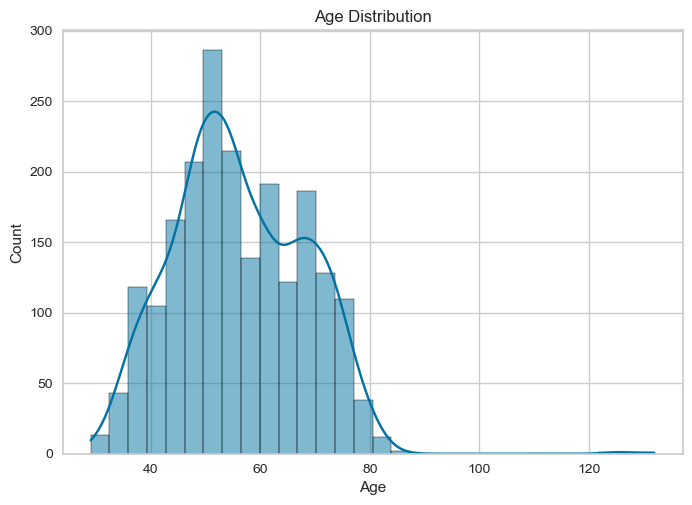

In [78]:
sns.histplot(df['Age'], bins = 30, kde = True)
plt.title("Age Distribution")
plt.show()

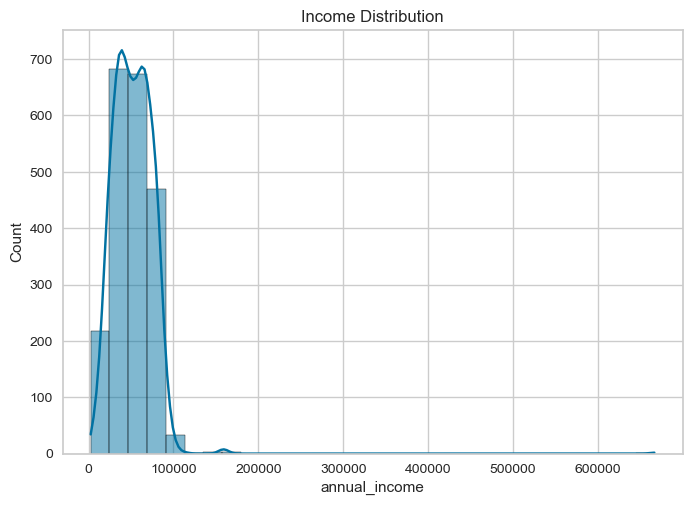

In [79]:
sns.histplot(df["annual_income"], bins = 30, kde = True)
plt.title("Income Distribution")
plt.show()

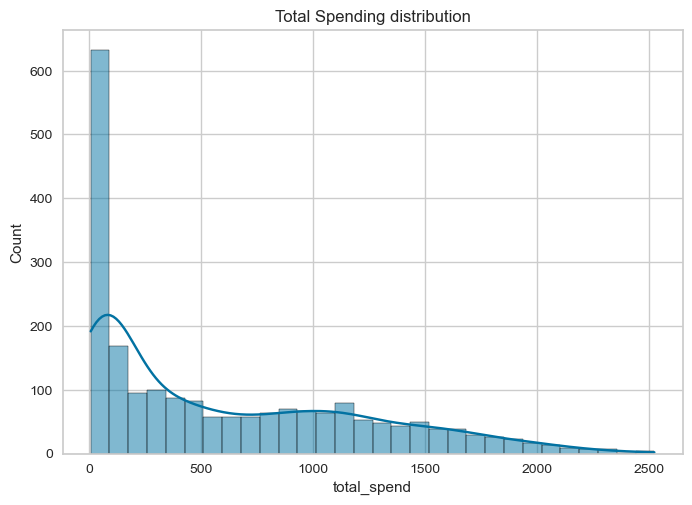

In [80]:
sns.histplot(df['total_spend'], bins =30 , kde = True)
plt.title("Total Spending distribution")
plt.show()

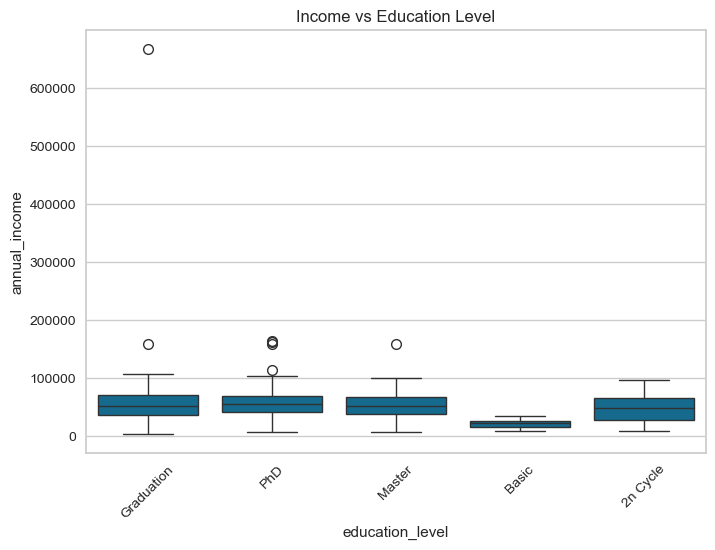

In [81]:
sns.boxplot(x = "education_level", y = "annual_income", data = df)
plt.xticks(rotation= 45)
plt.title("Income vs Education Level")
plt.show()

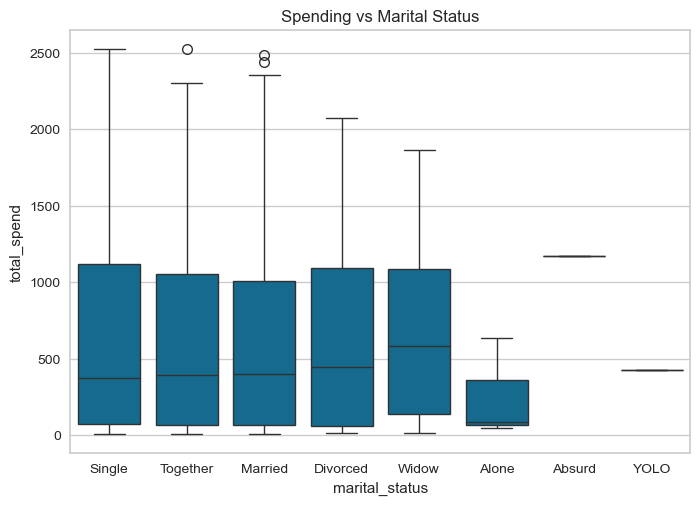

In [82]:
sns.boxplot(x='marital_status', y= 'total_spend', data = df)
plt.title("Spending vs Marital Status")
plt.show()

In [83]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

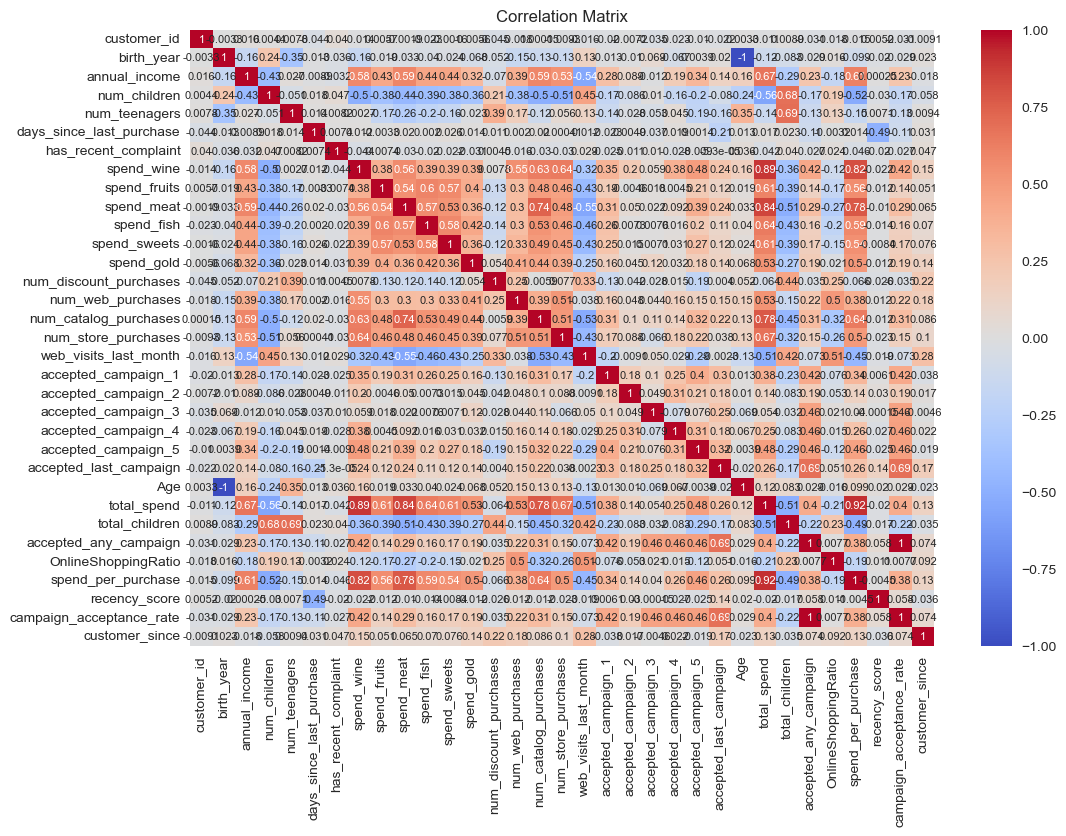

In [84]:
plt.figure(figsize = (12,8))
sns.heatmap(corr,annot=True , cmap="coolwarm", annot_kws={'size':8})
plt.title("Correlation Matrix")
plt.show()

In [85]:
pivot_income = df.pivot_table(values='annual_income', index = 'education_level', columns='marital_status', aggfunc='mean')
pivot_income

marital_status,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
education_level,,,,,,,,
2n Cycle,NaN,NaN,49395.130435,46328.392405,54532.742857,44561.763636,40972.666667,NaN
Basic,NaN,NaN,9548.000000,21777.210526,18788.125000,21240.071429,22123.000000,NaN
Graduation,NaN,34176.0,55095.537736,50709.963235,51486.472574,55769.357414,53891.818182,NaN
Master,65487.0,61331.0,50618.529412,53327.907692,54225.100000,52166.422680,56399.000000,NaN
PhD,NaN,35860.0,52523.645833,58283.825843,53058.157303,56744.311321,59342.695652,48432.0


Text(0.5, 1.0, 'Average Income by Marital Status and Education')

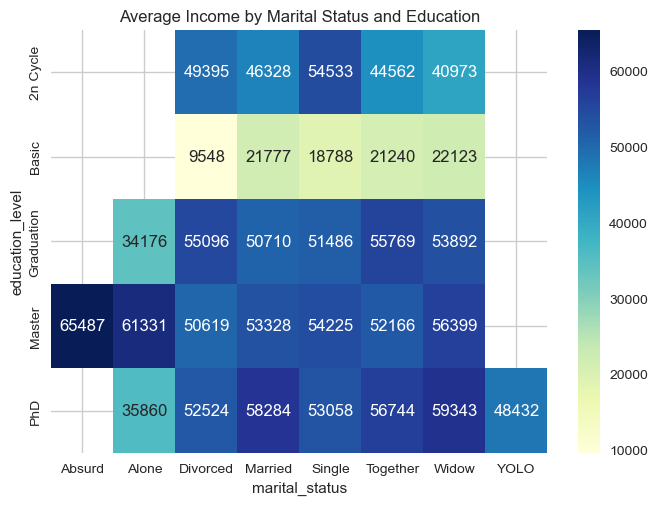

In [86]:
sns.heatmap(pivot_income, annot = True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Income by Marital Status and Education")

In [87]:
group1 = df.groupby('education_level')['total_spend'].mean().sort_values(ascending=False)
group1

education_level
PhD           677.165548
Graduation    622.901718
Master        616.897959
2n Cycle      491.902564
Basic          82.745098
Name: total_spend, dtype: float64

Text(0, 0.5, 'Average Spending')

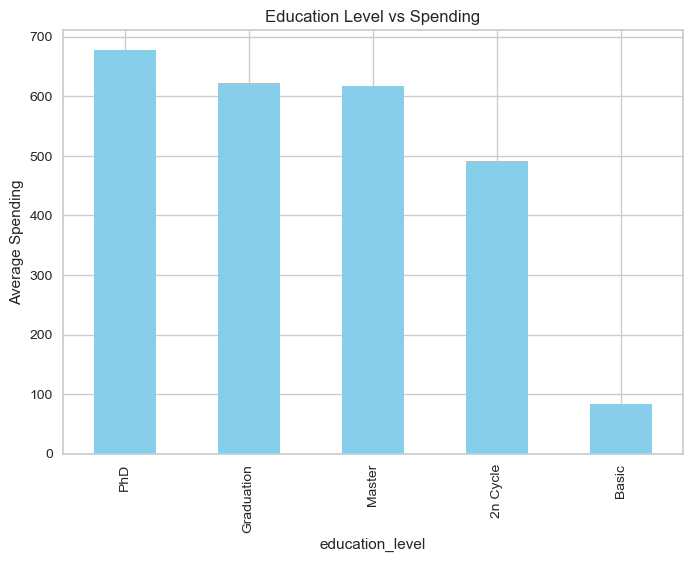

In [88]:
group1.plot(kind = 'bar', color  = 'skyblue')
plt.title("Education Level vs Spending")
plt.ylabel("Average Spending")

 21  accepted_campaign_1       2240 non-null   int64  
 22  accepted_campaign_2       2240 non-null   int64  
 23  accepted_campaign_3       2240 non-null   int64  
 24  accepted_campaign_4       2240 non-null   int64  
 25  accepted_campaign_5       2240 non-null   int64  
 26  accepted_last_campaign    2240 non-null   int64  

In [89]:
group2 = df.groupby('marital_status')['accepted_any_campaign'].mean().sort_values(ascending=False)
group2

marital_status
YOLO        0.500000
Alone       0.333333
Widow       0.314286
Single      0.308725
Divorced    0.297170
Married     0.255528
Together    0.252336
Absurd      0.000000
Name: accepted_any_campaign, dtype: float64

Text(0.5, 1.0, 'Average acceptance vs Marital Status')

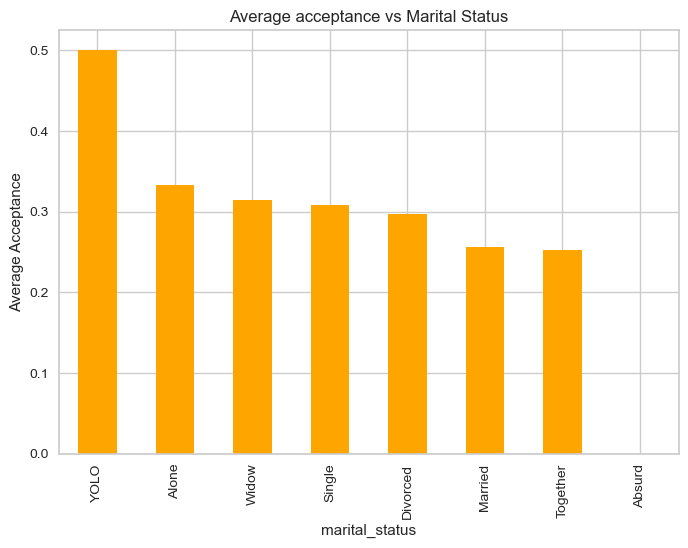

In [90]:
group2.plot(kind = 'bar', color = 'orange')
plt.ylabel('Average Acceptance')
plt.title("Average acceptance vs Marital Status" )

In [91]:
bins =[10,30,40,50,60,70,90]
labels = ["18-29","30-39", "40-49","50-59", "60-69","70+"]

In [92]:
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df['AgeGroup']


0       60-69
1         70+
2       50-59
3       40-49
4       40-49
        ...  
2235    50-59
2236      70+
2237    40-49
2238    60-69
2239      70+
Name: AgeGroup, Length: 2084, dtype: category
Categories (6, object): ['18-29' < '30-39' < '40-49' < '50-59' < '60-69' < '70+']

In [93]:
group3 = df.groupby('AgeGroup')['annual_income'].mean()
group3

AgeGroup
18-29    46658.000000
30-39    46314.698980
40-49    49024.804924
50-59    50860.639683
60-69    56452.527907
70+      58890.024138
Name: annual_income, dtype: float64

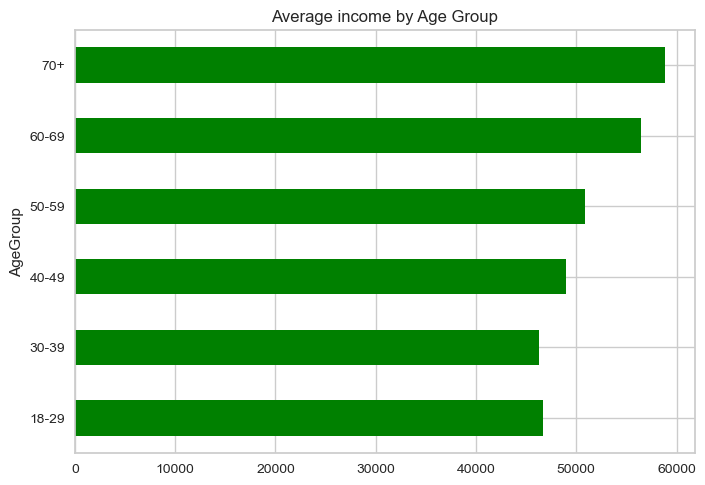

In [94]:
group3.plot(kind= 'barh', color = 'green')
plt.title("Average income by Age Group")
plt.show()

In [95]:
df.head()

,customer_id,birth_year,education_level,marital_status,annual_income,num_children,num_teenagers,signup_date,days_since_last_purchase,has_recent_complaint,...,Age,total_spend,total_children,accepted_any_campaign,OnlineShoppingRatio,spend_per_purchase,recency_score,campaign_acceptance_rate,customer_since,AgeGroup
0,5524,1957,Graduation,Single,58138.0,0,0.0,2012-04-09,58,0,...,68,1617,0.0,1,0.363636,73.500000,0.016949,1,4992,60-69
1,2174,1954,Graduation,Single,46344.0,1,1.0,2014-08-03,38,0,...,71,27,2.0,0,0.250000,6.750000,0.025641,0,4146,70+
2,4141,1965,Graduation,Together,71613.0,0,0.0,2013-08-21,26,0,...,60,776,0.0,0,0.400000,38.800000,0.037037,0,4493,50-59
3,6182,1984,Graduation,Together,26646.0,1,0.0,2014-10-02,26,0,...,41,53,1.0,0,0.333333,8.833333,0.037037,0,4086,40-49
4,5324,1981,PhD,Married,58293.0,1,0.0,2014-01-19,94,0,...,44,422,1.0,0,0.357143,30.142857,0.010526,0,4342,40-49


In [96]:
df.columns

Index(['customer_id', 'birth_year', 'education_level', 'marital_status',
       'annual_income', 'num_children', 'num_teenagers', 'signup_date',
       'days_since_last_purchase', 'has_recent_complaint', 'spend_wine',
       'spend_fruits', 'spend_meat', 'spend_fish', 'spend_sweets',
       'spend_gold', 'num_discount_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'web_visits_last_month',
       'accepted_campaign_1', 'accepted_campaign_2', 'accepted_campaign_3',
       'accepted_campaign_4', 'accepted_campaign_5', 'accepted_last_campaign',
       'Age', 'total_spend', 'total_children', 'accepted_any_campaign',
       'OnlineShoppingRatio', 'spend_per_purchase', 'recency_score',
       'campaign_acceptance_rate', 'customer_since', 'AgeGroup'],
      dtype='object')

In [97]:
outlier_cols = ['Age', 'annual_income']

In [98]:
df_clean = df.copy()

In [99]:
outlier_cols = ['annual_income', 'total_spend', 'Age', 'spend_per_purchase']

print(f"Rows before outlier removal: {len(df_clean)}")

for col in outlier_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Rows after outlier removal: {len(df_clean)}")

Rows before outlier removal: 2084
Rows after outlier removal: 1973


In [100]:
# Ordinal encoding for education (preserves order)
edu_map = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
df_clean['education_level'] = df_clean['education_level'].map(edu_map).fillna(1)

# Ordinal encoding for marital status
marital_map = {
    'Single': 1, 
    'Together': 2, 
    'Married': 3, 
    'Divorced': 4, 
    'Widow': 5,
    'Alone': 1,  # Treat as single
    'Absurd': 1, # Treat as single
    'YOLO': 1    # Treat as single
}
df_clean['marital_status'] = df_clean['marital_status'].map(marital_map).fillna(1)

print("Encoding complete.")

Encoding complete.


In [101]:
features = [
    # Ratio features 
    'OnlineShoppingRatio',
    'spend_per_purchase',
    'recency_score',
    # Core RFM
    'total_spend',
    'num_web_purchases',
    'num_store_purchases',
    'num_catalog_purchases',
    
    # Demographics
    'Age',
    'annual_income',
    'education_level',
    'total_children',
    
    # Additional behavior
    'web_visits_last_month',
    'customer_since',
    'campaign_acceptance_rate'
]

print(f"Using {len(features)} features including ratios")

Using 14 features including ratios


In [102]:
X = df_clean[features].copy()

In [103]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("MinMaxScaler applied (0-1 range).")

MinMaxScaler applied (0-1 range).



PCA Results:
PC1 explains: 0.371
PC2 explains: 0.210
Total variance: 0.580


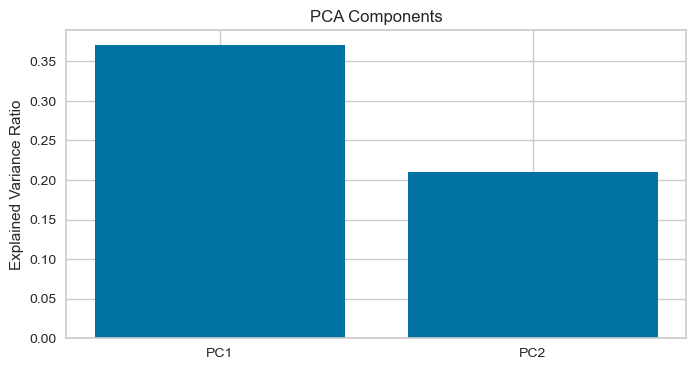

In [104]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA Results:")
print(f"PC1 explains: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2 explains: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total variance: {sum(pca.explained_variance_ratio_):.3f}")

# Visualize variance
plt.figure(figsize=(8, 4))
plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components')
plt.show()

In [105]:
from sklearn.metrics import silhouette_score

best_scores = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    best_scores[k] = score
    print(f"k={k}: Silhouette Score = {score:.3f}")


k=2: Silhouette Score = 0.590
k=3: Silhouette Score = 0.632
k=4: Silhouette Score = 0.680
k=5: Silhouette Score = 0.623
k=6: Silhouette Score = 0.595
k=7: Silhouette Score = 0.572
k=8: Silhouette Score = 0.548
k=9: Silhouette Score = 0.552
k=10: Silhouette Score = 0.521
k=11: Silhouette Score = 0.514
k=12: Silhouette Score = 0.502
k=13: Silhouette Score = 0.492
k=14: Silhouette Score = 0.466
k=15: Silhouette Score = 0.459
k=16: Silhouette Score = 0.459
k=17: Silhouette Score = 0.453
k=18: Silhouette Score = 0.449
k=19: Silhouette Score = 0.448


In [106]:
kmeans  = KMeans(n_clusters=4)
df_clean['Cluster'] = kmeans.fit_predict(X_pca)

In [107]:
cluster_summary = df_clean.groupby('Cluster')[features].mean()
cluster_summary

,OnlineShoppingRatio,spend_per_purchase,recency_score,total_spend,num_web_purchases,num_store_purchases,num_catalog_purchases,Age,annual_income,education_level,total_children,web_visits_last_month,customer_since,campaign_acceptance_rate
Cluster,,,,,,,,,,,,,,
0,0.293310,64.925617,0.063909,1319.429630,6.074074,8.814815,5.825926,58.370370,73582.300000,3.625926,0.344444,3.959259,4561.225926,1.0
1,0.351362,15.941330,0.052885,138.718354,2.670886,3.604430,0.654008,54.272152,36635.382911,3.319620,1.266878,6.329114,4506.276371,0.0
2,0.398781,23.401062,0.074650,281.351598,4.136986,3.936073,1.730594,55.000000,40279.538813,3.497717,1.264840,7.027397,4572.657534,1.0
3,0.292723,51.441174,0.047523,975.559701,5.641791,8.972015,4.492537,58.643657,66787.733209,3.513060,0.692164,3.815299,4545.783582,0.0


In [108]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

features = [
    # Computed Features (Logic required in App)
    'OnlineShoppingRatio', 
    'spend_per_purchase', 
    'recency_score',
    'campaign_acceptance_rate',
    
    # Raw Features (Direct Input in App)
    'total_spend',
    'num_web_purchases',
    'num_store_purchases',
    'num_catalog_purchases',
    'Age',
    'annual_income',
    'education_level',
    'total_children',
    'web_visits_last_month',
    'customer_since' 
]

X = df_clean[features]
y = df_clean['Cluster'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9772151898734177
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        45
           1       0.99      0.98      0.99       207
           2       1.00      0.93      0.96        44
           3       0.96      0.98      0.97        99

    accuracy                           0.98       395
   macro avg       0.97      0.97      0.97       395
weighted avg       0.98      0.98      0.98       395

